In [ ]:
import quantbt as qbt
import pandas as pd
from quantbt.core.enums import TradeMode

data = qbt.data.random_data(seed=300)[0]
print(data)

import quantbt.indicators as ind
from quantbt.strategies.S_base import S_base
from quantbt.core.enums import CommissionType, DataType, TradeSizeType


class MyStrategy(S_base):
    def generate_signals(self):
        short_period, long_period = self.params

        self.sma_short = ind.talib_SMA(data.close, period=short_period)
        self.sma_long = ind.talib_SMA(data.close, period=long_period)
        self.long = ind.cross_above(self.sma_short, self.sma_long)
        self.short = ind.cross_below(self.sma_short, self.sma_long)

        return {
            "long_entries": self.long,
            "long_exits": self.short,
            "short_entries": self.short,
            "short_exits": self.long,
        }


strategy_settings = {
    "initial_capital": 100_000,
    "commission": 1.2,
    "commission_type": CommissionType.FIXED,
    "multiplier": 20,
    "data_type": DataType.OHLC,
    "default_trade_size": 1,
    "trade_size_type": TradeSizeType.FIXED,
}


"""
This is how we actually backtest the strategy.
We only need to set the parameters which will be automatically passed to the st.generate_signals() function
"""
st = MyStrategy(data, **strategy_settings)
st.set_backtester_settings(
    use_trailing_sl=False, one_trade_per_direction=False, trade_mode=TradeMode.HEDGE
)

params = (49, 44)
st.from_signals(params)

: 

In [2]:
stats = st.get_stats()
print(stats)

              End Value  ROI: (%)    DD     ratio
(49, 44)  102279.882812      2.28  0.51  4.470588


In [3]:
trades = st.get_trades()
print(trades)

     IDX  Index  Direction  EntryTime  ...  Commission Active  CloseReason  Extra
0    0.0  114.0        1.0 2023-04-25  ...         2.4    0.0       SIGNAL   -1.0
1    1.0  151.0        0.0 2023-06-01  ...         2.4    0.0       SIGNAL   -1.0
2    2.0  191.0        1.0 2023-07-11  ...         2.4    0.0       SIGNAL   -1.0
3    3.0  207.0        0.0 2023-07-27  ...         2.4    0.0       SIGNAL   -1.0
4    4.0  280.0        1.0 2023-10-08  ...         2.4    0.0       SIGNAL   -1.0
5    5.0  286.0        0.0 2023-10-14  ...         2.4    0.0       SIGNAL   -1.0
6    6.0  311.0        1.0 2023-11-08  ...         2.4    0.0       SIGNAL   -1.0
7    7.0  323.0        0.0 2023-11-20  ...         2.4    0.0       SIGNAL   -1.0
8    8.0  359.0        1.0 2023-12-26  ...         2.4    0.0       SIGNAL   -1.0
9    9.0  366.0        0.0 2024-01-02  ...         2.4    0.0       SIGNAL   -1.0
10  10.0  411.0        1.0 2024-02-16  ...         2.4    0.0       SIGNAL   -1.0
11  11.0  443.0 

            equity       Date         Bid  ...           High            Low          Close
0    100000.000000 2023-01-01   96.509250  ...  100000.000000  100000.000000  100000.000000
1    100000.000000 2023-01-02   93.660119  ...  100000.000000  100000.000000  100000.000000
2    100000.000000 2023-01-03   91.877321  ...  100000.000000  100000.000000  100000.000000
3    100000.000000 2023-01-04   93.399648  ...  100000.000000  100000.000000  100000.000000
4    100000.000000 2023-01-05   92.002133  ...  100000.000000  100000.000000  100000.000000
..             ...        ...         ...  ...            ...            ...            ...
993  102300.828125 2025-09-20  105.719719  ...  102300.828125  102300.828125  102300.828125
994  102295.796875 2025-09-21  105.468077  ...  102295.796875  102295.796875  102295.796875
995  102296.640625 2025-09-22  105.510429  ...  102296.640625  102296.640625  102296.640625
996  102279.882812 2025-09-23  104.672318  ...  102279.882812  102279.882812  10

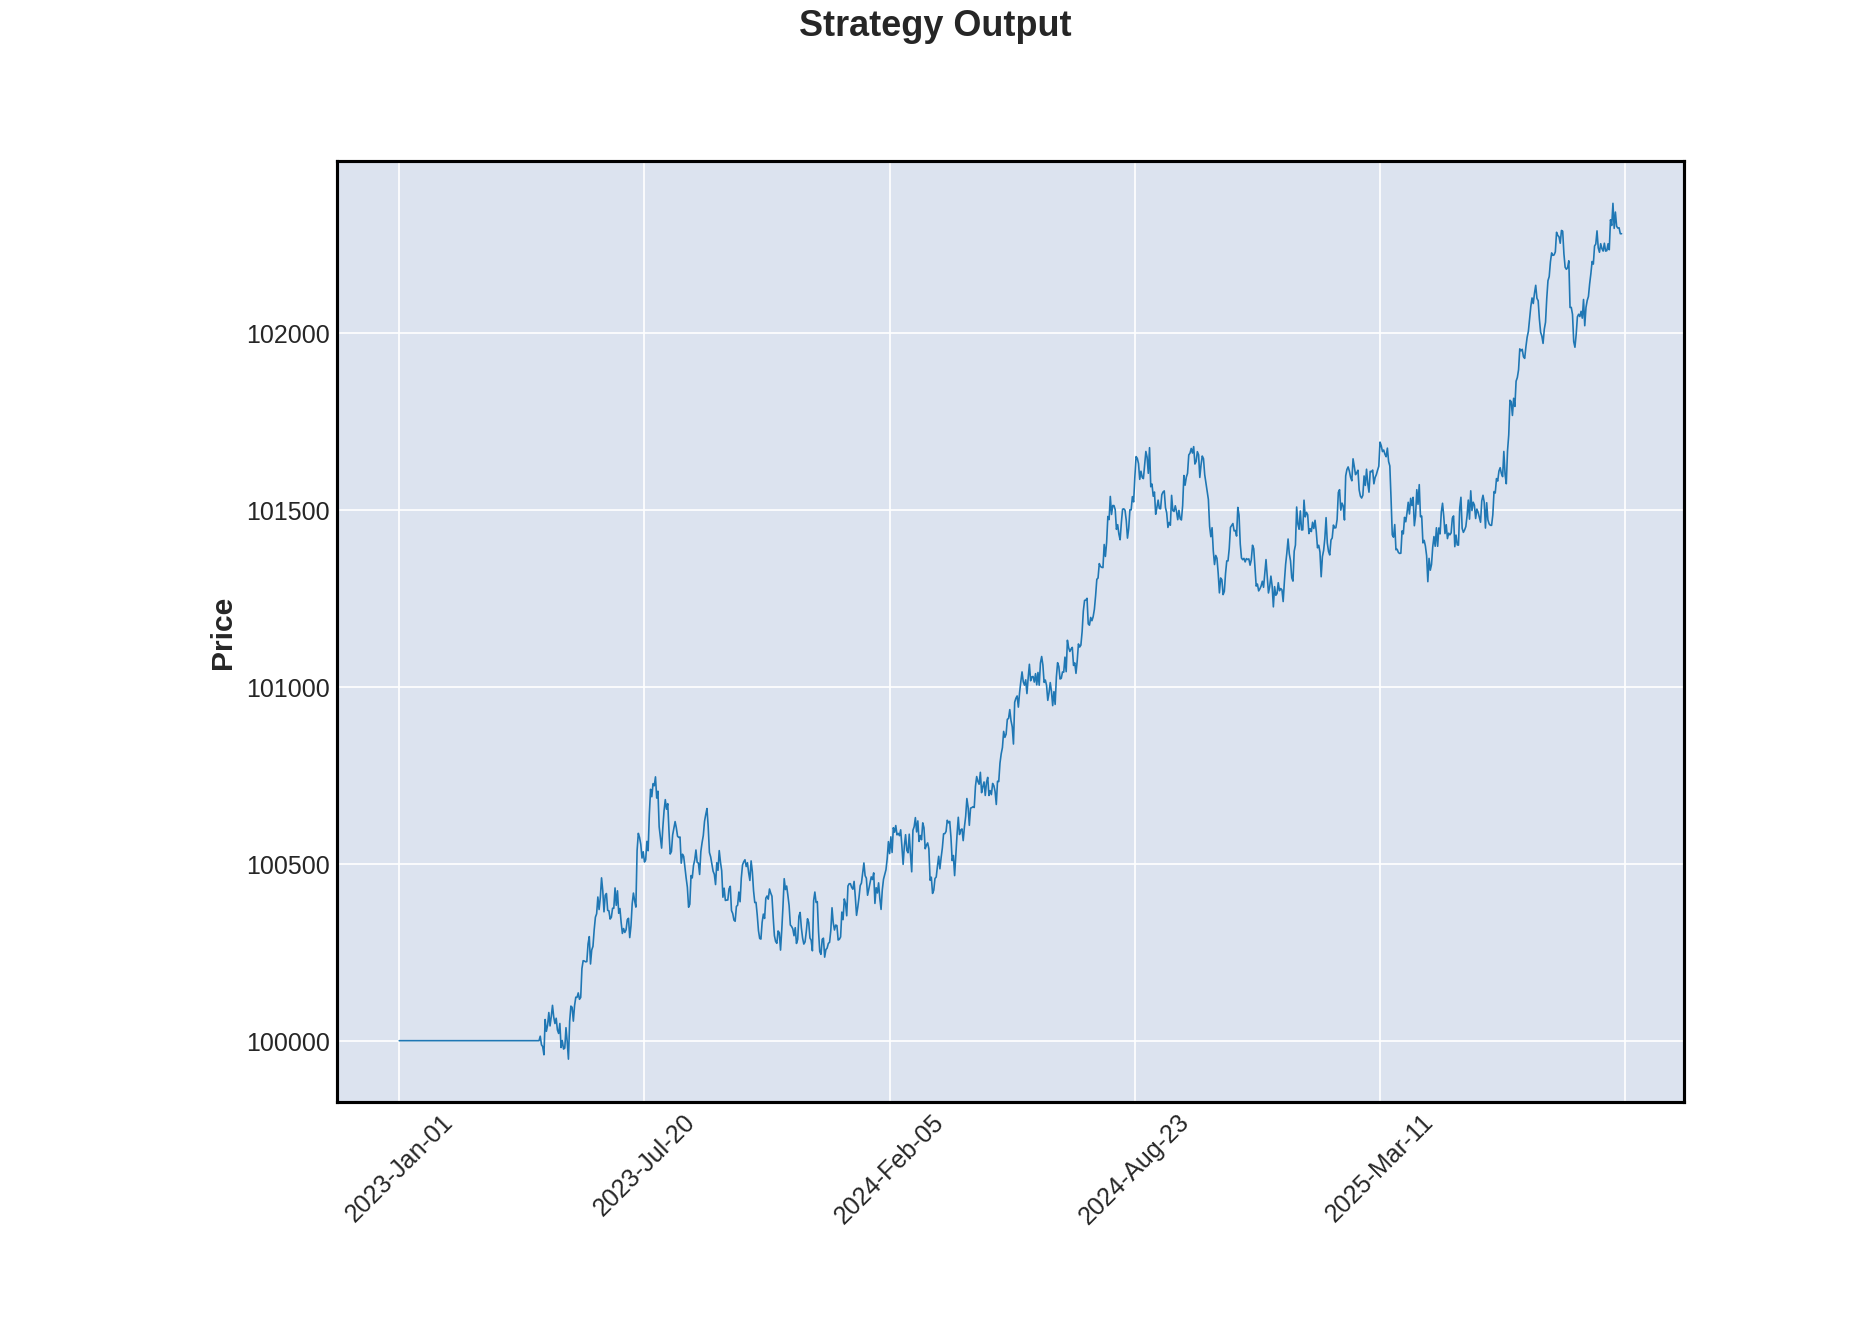

In [4]:
st.plot_equity()

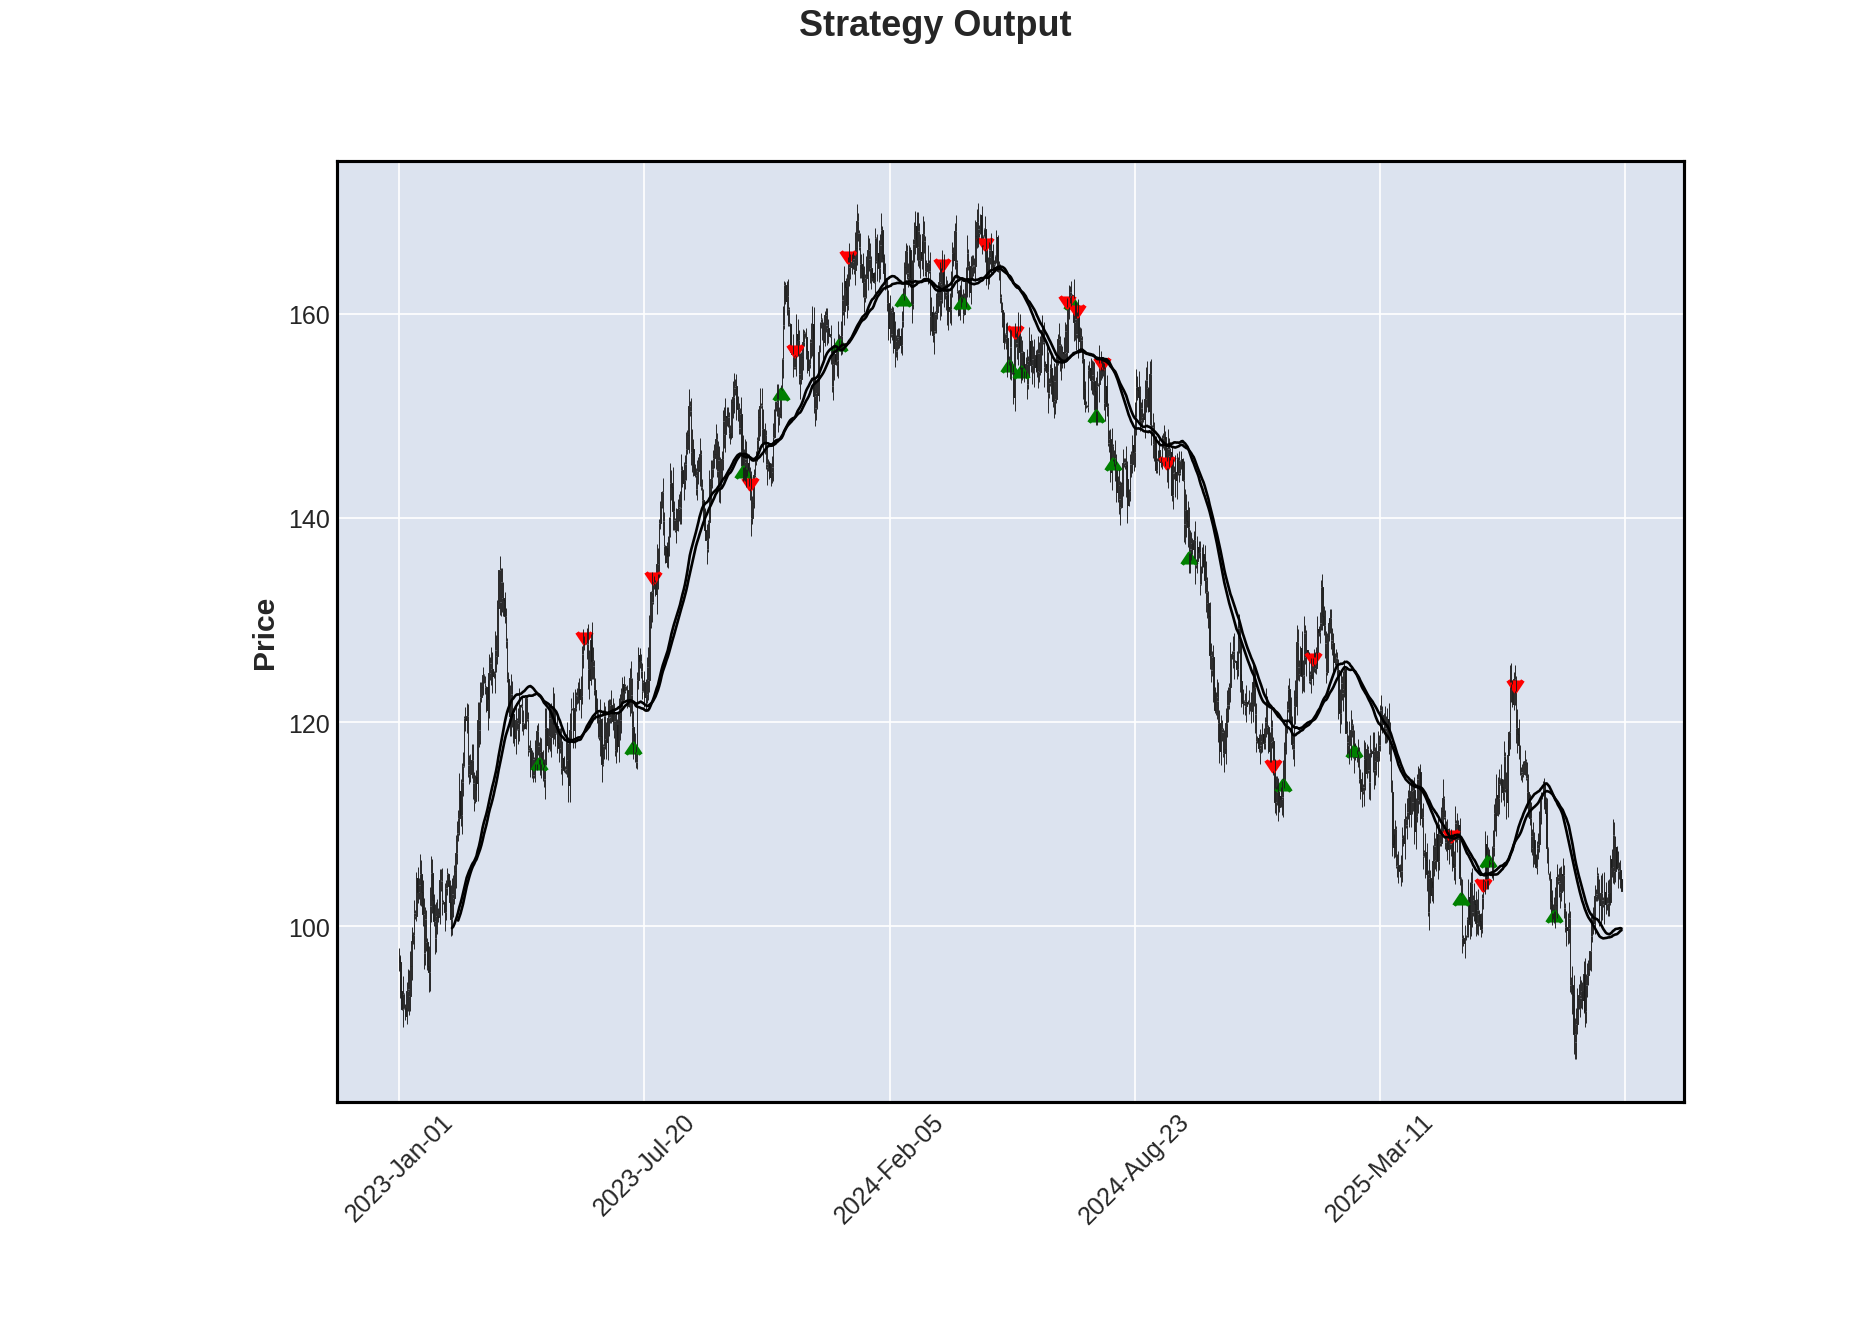

In [5]:
"""
Plotting the equity, adding the 2 MA lines, as well as markers for long and short entry signals
"""

import matplotlib

plotting = qbt.lib.plotting
subplots = [
    plotting.add_line_plot(st.sma_short),
    plotting.add_line_plot(st.sma_long),
    plotting.add_markers(
        st.long, data.close, color="green", marker_type=matplotlib.markers.CARETUP
    ),
    plotting.add_markers(st.short, data.close, color="red"),
]


qbt.lib.plotting.mpf_plot(data, subplots=subplots)

In [ ]:
import pandas as pd
from quantbt.lib import time_manip
from quantbt.lib.data_to_csv import save_data, create_scatter_df


data["Date"] = time_manip.convert_datetime_to_ms(data.index)
time_manip.convert_datetime_to_ms(data["Date"])

"""
Create the dataframes needed for the UI
"""
df = pd.DataFrame(
    {
        "date": data["Date"],
        "open": data.open,
        "high": data.high,
        "low": data.low,
        "close": data.close,
        "long": st.long,
        "short": st.short,
        "equity": st.bt.data_module.equity,
    }
)
df.index = df["date"]

# Apply the function to create the new column


# rsi_scatter_high = data['high']
# rsi_scatter_low = data['high']

indicators_data = pd.DataFrame(
    {"ma1": st.sma_long, "ma2": st.sma_short, "equity": st.bt.data_module.equity}
)

"""
Create the configuration that tells the UI which indicators to draw
"""
indicators = [
    {"name": "EMA Long", "type": "line", "panel": 0, "dataIndex": 0},
    {"name": "MA Short", "type": "line", "color": "black", "panel": 0, "dataIndex": 1},
    {"name": "Equity", "type": "line", "color": "black", "panel": 1, "dataIndex": 2},
]


"""
Save the data and config to the location of the UI
"""
UI_LOCATION = "./candles-ui/public"

save_data(
    UI_LOCATION, df, indicators, indicators_data, st.bt.trade_module.closed_trades
)

In [ ]:
# Optimisation
new_df = pd.DataFrame()
for short in range(2, 50):
    for long in range(21, 89):
        st.from_signals((short, long))
        stats = st.get_stats()
        new_df = pd.concat([new_df, stats])
print(new_df)

sorted_optimisation = new_df.sort_values("ratio", ascending=False)
print(sorted_optimisation)